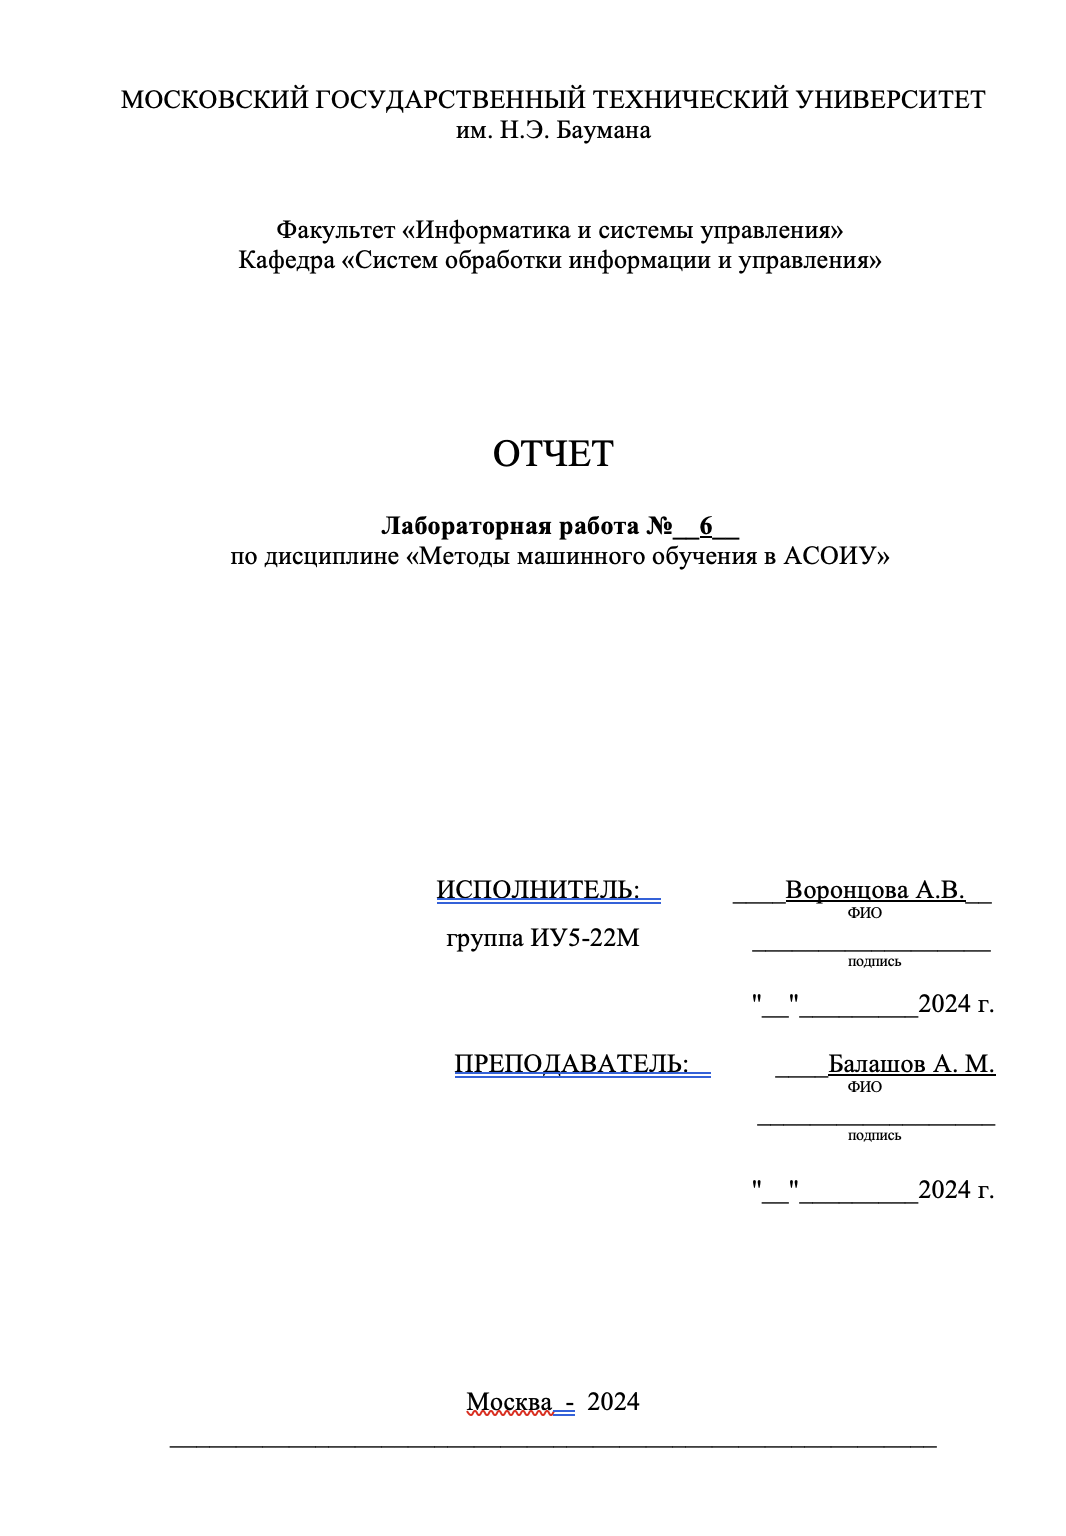

### **Задание:**
На основе рассмотренных на лекции примеров реализуйте алгоритм DQN.
В качестве среды можно использовать классические среды (в этом случае используется полносвязная архитектура нейронной сети).

Для реализации алгоритма Deep Q-Network (DQN) на Python, я буду использовать библиотеку gym для симуляции среды и torch для создания и обучения нейронной сети. В качестве среды для DQN используем CartPole-v1 из библиотеки gym.

In [1]:
pip install gym[atari,accept-rom-license] torch torchvision


Episode: 0, Total reward: 24.0, Epsilon: 0.995
Episode: 1, Total reward: 22.0, Epsilon: 0.990025
Episode: 2, Total reward: 17.0, Epsilon: 0.985074875
Episode: 3, Total reward: 29.0, Epsilon: 0.9801495006250001
Episode: 4, Total reward: 15.0, Epsilon: 0.9752487531218751
Episode: 5, Total reward: 21.0, Epsilon: 0.9703725093562657
Episode: 6, Total reward: 11.0, Epsilon: 0.9655206468094844
Episode: 7, Total reward: 23.0, Epsilon: 0.960693043575437
Episode: 8, Total reward: 22.0, Epsilon: 0.9558895783575597
Episode: 9, Total reward: 41.0, Epsilon: 0.9511101304657719
Episode: 10, Total reward: 47.0, Epsilon: 0.946354579813443
Episode: 11, Total reward: 24.0, Epsilon: 0.9416228069143757
Episode: 12, Total reward: 15.0, Epsilon: 0.9369146928798039
Episode: 13, Total reward: 29.0, Epsilon: 0.9322301194154049
Episode: 14, Total reward: 26.0, Epsilon: 0.9275689688183278
Episode: 15, Total reward: 13.0, Epsilon: 0.9229311239742362
Episode: 16, Total reward: 21.0, Epsilon: 0.918316468354365
Episod

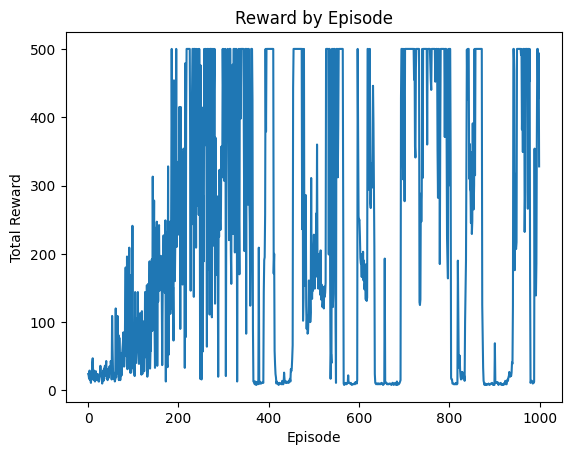

In [31]:
import gym
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

class Agent:
    def __init__(self, state_space, action_space, lr=0.001, gamma=0.99):
        self.state_space = state_space
        self.action_space = action_space
        self.gamma = gamma
        self.memory = deque(maxlen=10000)
        self.model = DQN(state_space, action_space)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

    def update(self, batch_size):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.model(next_states).max(1)[0]
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = self.criterion(q_values, expected_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.model(state)
            action = q_values.max(1)[1].item()
        else:
            action = random.randrange(self.action_space)
        return action

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

def train():
    env = gym.make('CartPole-v1')
    agent = Agent(env.observation_space.shape[0], env.action_space.n)
    episodes = 1000
    batch_size = 32
    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995
    epsilon = epsilon_start

    rewards = []  # Список для хранения вознаграждений

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            agent.update(batch_size)

        rewards.append(total_reward)  # Добавляем вознаграждение за эпизод
        epsilon = max(epsilon_end, epsilon_decay * epsilon)
        print(f"Episode: {episode}, Total reward: {total_reward}, Epsilon: {epsilon}")

    plt.plot(rewards)
    plt.title('Reward by Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()

if __name__ == "__main__":
    train()